## Run SVGPR+PS on NC data!

In [79]:
# Imports
from tqdm.notebook import tqdm
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import sys
sys.path.append('../')
from models.svgpr_ps_new import SVGPR_PS_BLOCKS_NEW
from sklearn.impute import KNNImputer

import pyro
import tqdm
import random

import os, re
from datetime import date
import geopandas as gpd
from shapely.geometry import mapping
from rasterstats import zonal_stats
from scipy.stats import pearsonr

In [80]:
# Set parameters for input data
census_group_type = 'block_group' #'tract' or 'block_group'
wu_date = 'jul23_2021'
time_slot = 'eve' # morn, af, eve

# Set parameters for fitting, training
n_inducing = 800
num_epochs = 300
lr = 0.01

# Which city do we want to compare for this date?
city_name = 'raleigh'
county_prefixes = ["37183"] # charlotte: ["37119"], durham: ["37063"], raleigh: ["37183"], asheville: ["37021"], CH: ["37135", "37063", "37037"]

# Set random seeds
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); pyro.set_rng_seed(seed)

In [81]:
# WU time slot determines what LST column name is
if time_slot in ["morn", "af"]:
    t_s_col = "t_s_day"
elif time_slot == "eve":
    t_s_col = "t_s_night"
else:
    raise ValueError("Invalid time_slot. Must be 'morn', 'af', or 'eve.'")

Load and prepare data.

In [82]:
# STATIONS (slot-filtered, one robust value per station)
from datasets.process_wu_data import load_and_filter_wu_data, filter_by_time_slot_local_last5min
obs_wu = load_and_filter_wu_data(f"data/{wu_date}/{wu_date}_wu.csv")

_MON = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,
        "jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}

def wu_date_to_target_date(wu_date: str) -> str:
    """
    Convert things like 'jul23_2021', 'Jul_23_2021', 'data/jul23_2021',
    or ISO-ish forms ('2021-07-23', '20210723', '2021_07_23')
    into 'YYYY-MM-DD'.
    """
    s = os.path.basename(str(wu_date)).lower()

    # ISO-ish first
    m = re.fullmatch(r"(\d{4})[-_]?(\d{2})[-_]?(\d{2})", s)
    if m:
        y, mth, d = map(int, m.groups())
        return date(y, mth, d).isoformat()

    # monDD_YYYY with optional underscore between mon and DD
    m = re.fullmatch(r"([a-z]{3})_?(\d{1,2})_(\d{4})", s)
    if m:
        mon, d, y = m.groups()
        mm = _MON.get(mon)
        if mm is None:
            raise ValueError(f"Unknown month abbr: {mon}")
        return date(int(y), mm, int(d)).isoformat()

    # Embedded patterns inside longer strings
    m = re.search(r"([a-z]{3})_?(\d{1,2})_(\d{4})", s)
    if m:
        mon, d, y = m.groups()
        mm = _MON.get(mon)
        if mm:
            return date(int(y), mm, int(d)).isoformat()

    m = re.search(r"(\d{4})[-_]?(\d{2})[-_]?(\d{2})", s)
    if m:
        y, mth, d = map(int, m.groups())
        return date(y, mth, d).isoformat()

    raise ValueError(f"Could not parse wu_date: {wu_date}")

target_date = wu_date_to_target_date(wu_date)
print(target_date)
obs_slot = filter_by_time_slot_local_last5min(
    obs_wu, target_date=target_date, slot=time_slot, tz="America/New_York"
)
stations = (obs_slot
    .groupby("station", as_index=False)
    .agg({"lat":"median","lon":"median","tempAvg":"median"})
)

2021-07-23


In [83]:
# POLYGONS (water drop, centroids in WGS84), build df_full (one row per polygon)
if census_group_type == "tract":
    df_geo  = pd.read_csv(f"data/{wu_date}/nc_tracts_temp_pop_{time_slot}.csv")
    df_elev = pd.read_csv(f"data/{wu_date}/nc_tracts_elev_{t_s_col}_{time_slot}.csv")
    shp_file = f"data/{wu_date}/nc_tracts_temp_pop_{time_slot}.shp"
else:
    df_geo  = pd.read_csv(f"data/{wu_date}/nc_bg_temp_pop_{time_slot}.csv")
    df_elev = pd.read_csv(f"data/{wu_date}/nc_bg_elev_{t_s_col}_{time_slot}.csv")
    shp_file = f"data/{wu_date}/nc_bg_temp_pop_{time_slot}.shp"

for df in (df_geo, df_elev):
    df["GEOID"] = df["GEOID"].astype(str)

areal_units = gpd.read_file(shp_file).copy()
areal_units["GEOID"] = areal_units["GEOID"].astype(str)
water_ids = set(areal_units.loc[(areal_units["ALAND"]==0) & (areal_units["AWATER"]>0), "GEOID"])
areal_units = areal_units.loc[~areal_units["GEOID"].isin(water_ids)]

df_geo  = df_geo.loc[~df_geo["GEOID"].isin(water_ids)].copy()
df_elev = df_elev.loc[~df_elev["GEOID"].isin(water_ids)].copy()

# centroids in WGS84
units_m = areal_units.to_crs(3857); units_m["centroid"] = units_m.geometry.centroid
cent_ll = units_m.set_geometry("centroid").to_crs(4326)
areal_units["cent_lat"] = cent_ll.geometry.y
areal_units["cent_lon"] = cent_ll.geometry.x

df_full = (
    df_geo.merge(df_elev[["GEOID","elevation", t_s_col]], on="GEOID", how="left")
          .merge(areal_units[["GEOID","cent_lat","cent_lon"]], on="GEOID", how="left")
)


In [84]:
# IMPUTE COVARIATES (elevation, LST)
from sklearn.impute import KNNImputer
imp = KNNImputer(n_neighbors=5, weights="distance")
df_full[["elevation", t_s_col]] = imp.fit_transform(df_full[["elevation", t_s_col]])

# SHARED SCALERS
# 1. scaler fit on STATIONS, then applied to stations and centroids
st_np   = stations[["lat","lon"]].to_numpy()
mu_xy   = st_np.mean(axis=0)
std_xy  = st_np.std(axis=0) + 1e-12
st_xy_z = (st_np - mu_xy)/std_xy
cent_xy = df_full[["cent_lat","cent_lon"]].to_numpy()
cent_xy_z = (cent_xy - mu_xy)/std_xy

# 2. covariate standardization using POLYGON stats; will reuse these everywhere
elev_mu, elev_sd = df_full["elevation"].mean(), df_full["elevation"].std() + 1e-12
lst_mu,  lst_sd  = df_full[t_s_col].mean(),     df_full[t_s_col].std()  + 1e-12

df_full["elev_z"] = (df_full["elevation"] - elev_mu)/elev_sd
df_full["lst_z"]  = (df_full[t_s_col]     - lst_mu) /lst_sd

In [85]:
# map station points → polygon covariates (within, then nearest in metric CRS if needed)
gdf_poly = areal_units[["GEOID","geometry"]].copy()
gdf_poly["elevation"] = df_full.set_index("GEOID").loc[gdf_poly["GEOID"], "elevation"].values
gdf_poly[t_s_col]     = df_full.set_index("GEOID").loc[gdf_poly["GEOID"], t_s_col].values
gdf_pts = gpd.GeoDataFrame(
    stations.copy(),
    geometry=gpd.points_from_xy(stations["lon"], stations["lat"]),
    crs=4326
)
pts_in = gpd.sjoin(gdf_pts.to_crs(4326),
                   gdf_poly[["GEOID","elevation", t_s_col, "geometry"]].to_crs(4326),
                   how="left", predicate="within")
miss = pts_in["GEOID"].isna()
if miss.any():
    METRIC = "EPSG:32119"
    pts_fix = gpd.sjoin_nearest(
        gdf_pts.loc[miss].to_crs(METRIC),
        gdf_poly.to_crs(METRIC)[["GEOID","elevation", t_s_col, "geometry"]],
        how="left", distance_col="dist_m"
    )
    for c in ["GEOID","elevation", t_s_col]:
        pts_in.loc[miss, c] = pts_fix[c].values

elev_pts_z = (pts_in["elevation"].to_numpy() - elev_mu)/elev_sd
lst_pts_z  = (pts_in[t_s_col].to_numpy()     - lst_mu)/lst_sd


In [86]:
# TENSORS ready for all stages:
# Kriging inputs
X_pts   = torch.tensor(np.column_stack([st_xy_z, elev_pts_z, lst_pts_z]), dtype=torch.float32)  # [lat_z, lon_z, elev_z, lst_z]
y_pts   = torch.tensor(stations["tempAvg"].to_numpy(), dtype=torch.float32)
X_cent  = torch.tensor(np.column_stack([cent_xy_z, df_full["elev_z"], df_full["lst_z"]]), dtype=torch.float32)
population = torch.tensor(df_full["population"].to_numpy(), dtype=torch.float32)   # aligned to df_full
counts     = torch.tensor(df_full["count"].to_numpy(),      dtype=torch.float32)   # aligned to df_full

Get Kriging results first.

In [87]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import LinearMean
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch
from tqdm import trange

class KrigeGP(ExactGP):
    def __init__(self, X, y, lik):
        super().__init__(X, y, lik)
        self.mean_module = LinearMean(input_size=3) # mean over (lat_z, elev_z, lst_z)
        # self.covar_module = ScaleKernel(
        #     MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0, 1]) # only lat/lon in kernel (baseline)
        # )
        
        # # ADDITIVE KERNEL VERSION:
        # Kspace = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0,1])) # lat, lon
        # Kelev  = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=1, active_dims=[2])) # elev
        # self.covar_module = Kspace + Kelev

        # MULTIPLICATIVE KERNEL VERSION:
        Kspace = MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0,1])
        Kelev  = MaternKernel(nu=1.5, ard_num_dims=1, active_dims=[2])
        self.covar_module = ScaleKernel(Kspace * Kelev)


    def forward(self, x):
        # mean = self.mean_module(x[:, 2:4])
        mean_feats = torch.cat([x[:, 0:1], x[:, 2:3], x[:, 3:4]], dim=-1)  # [lat_z, elev_z, lst_z]
        mean = self.mean_module(mean_feats)
        cov  = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, cov)


lik = GaussianLikelihood() # don't set prior on noise
model = KrigeGP(X_pts, y_pts, lik)

model.train()
lik.train()
opt = torch.optim.Adam(model.parameters(), lr=0.05)
mll = ExactMarginalLogLikelihood(lik, model)

n_epochs = 300
pbar = trange(n_epochs, desc="Training KrigeGP", leave=True)

for i in pbar:
    opt.zero_grad()
    with gpytorch.settings.cholesky_jitter(1e-4): # avoid numerical warnings
        out = model(X_pts)
        loss = -mll(out, y_pts)
    loss.backward()
    opt.step()
    pbar.set_postfix({"Loss": f"{loss.item():.3f}"})

Training KrigeGP: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s, Loss=1.637]


In [88]:
model.eval(); lik.eval()
with torch.no_grad():
    post_lat = model(X_cent)  # latent f
    post_obs = lik(model(X_cent))  # observation y = f + noise

m_cent = post_lat.mean.cpu().numpy()
v_cent = post_obs.variance.cpu().numpy()

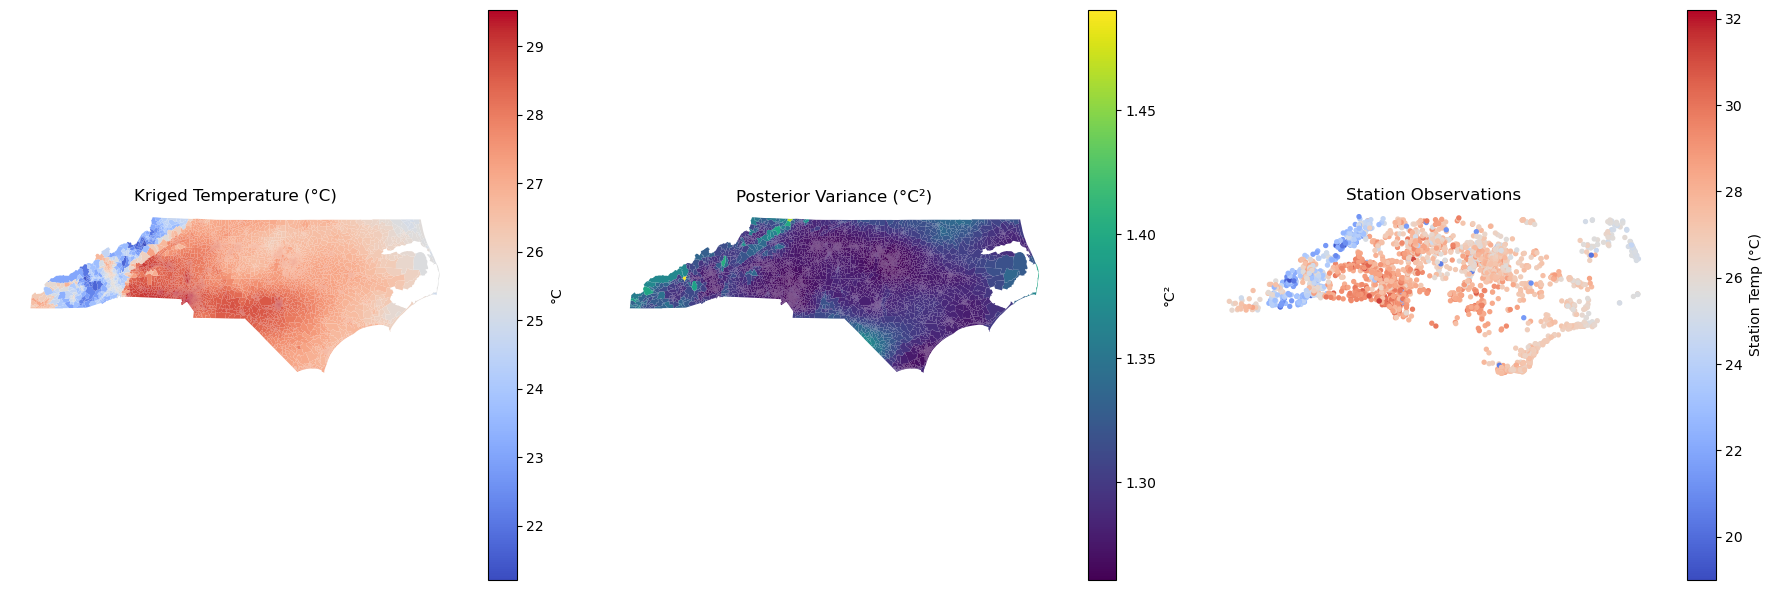

In [89]:
# Attach those predictions to df_full
df_full["krige_mean_C"] = m_cent
df_full["krige_var_C2"] = v_cent

# merge predictions into polygons
gdf_pred = areal_units.merge(
    df_full[["GEOID","krige_mean_C","krige_var_C2"]],
    on="GEOID", how="left"
)

# points GeoDataFrame for stations
gdf_pts = gpd.GeoDataFrame(
    stations.copy(),
    geometry=gpd.points_from_xy(stations["lon"], stations["lat"]),
    crs="EPSG:4326"
)

# pick a common CRS for plotting (Web Mercator)
gdf_pred_pm = gdf_pred.to_crs(3857)
gdf_pts_pm  = gdf_pts.to_crs(3857)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) kriged mean
gdf_pred_pm.plot(
    column="krige_mean_C", cmap="coolwarm", ax=axes[0],
    legend=True, legend_kwds={"label":"°C"}
)
axes[0].set_title("Kriged Temperature (°C)")
axes[0].axis("off")

# 2) posterior variance
gdf_pred_pm.plot(
    column="krige_var_C2", cmap="viridis", ax=axes[1],
    legend=True, legend_kwds={"label":"°C²"}
)
axes[1].set_title("Posterior Variance (°C²)")
axes[1].axis("off")

# 3) station observations (points) over polygon outlines
# gdf_pred_pm.boundary.plot(ax=axes[2], linewidth=0.3, color="lightgray")
sc = gdf_pts_pm.plot(
    ax=axes[2], markersize=8, column="tempAvg", cmap="coolwarm", legend=True,
    legend_kwds={"label":"Station Temp (°C)"}
)
axes[2].set_title("Station Observations")
axes[2].axis("off")

plt.tight_layout()
plt.show()

plt.show()

Visualize kriging results for just the city of interest, e.g. Durham:

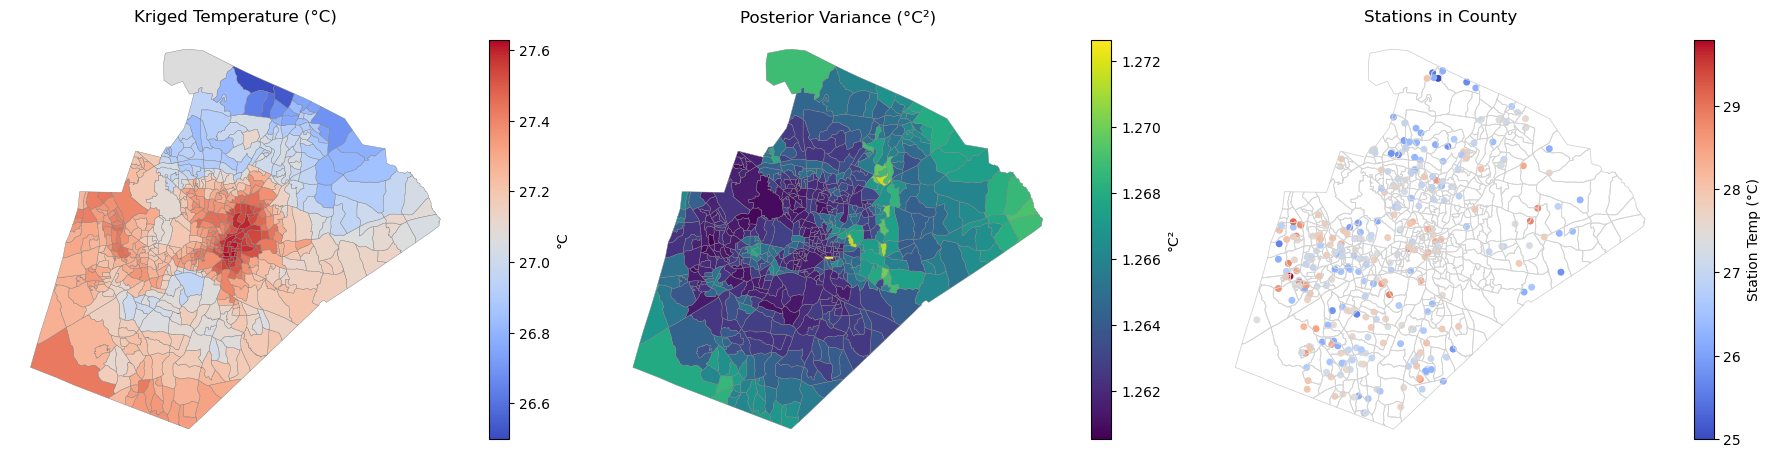

In [90]:
# Filter polygons to the county and clean geometry columns
# county_gdf = gdf_pred.loc[gdf_pred["GEOID"].astype(str).str.startswith(county_prefix)].copy()
county_gdf = gdf_pred.loc[gdf_pred["GEOID"].astype(str).str.startswith(tuple(county_prefixes))].copy()
county_gdf = county_gdf.to_crs(3857)

# Clip stations to the county boundary
gdf_pts_4326 = gdf_pts.to_crs(4326)
county_4326  = county_gdf.to_crs(4326)
pts_in_cty = gpd.sjoin(gdf_pts_4326, county_4326[["geometry"]], how="inner", predicate="within") \
                .drop(columns="index_right") \
                .to_crs(3857)

# Fix color scales (per-county) so both maps use the same ranges
vmin_T = float(county_gdf["krige_mean_C"].min())
vmax_T = float(county_gdf["krige_mean_C"].max())
vmin_V = float(county_gdf["krige_var_C2"].min())
vmax_V = float(county_gdf["krige_var_C2"].max())

# Plot: kriged mean, kriged variance, stations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Figure (a): Kriged mean
county_gdf.plot(
    column="krige_mean_C", cmap="coolwarm", ax=axes[0], edgecolor="gray", linewidth=0.3,
    legend=True, vmin=vmin_T, vmax=vmax_T, legend_kwds={"label": "°C", "shrink": 0.7}
)
axes[0].set_title("Kriged Temperature (°C)")
axes[0].axis("off")

# Figure (b): Posterior variance
county_gdf.plot(
    column="krige_var_C2", cmap="viridis", ax=axes[1], edgecolor="gray", linewidth=0.3,
    legend=True, vmin=vmin_V, vmax=vmax_V, legend_kwds={"label": "°C²", "shrink": 0.7}
)
axes[1].set_title("Posterior Variance (°C²)")
axes[1].axis("off")

# Figure (c): Stations with county outline
county_gdf.boundary.plot(ax=axes[2], color="lightgray", linewidth=0.6)
pts_in_cty.plot(
    ax=axes[2], column="tempAvg", cmap="coolwarm", markersize=16, legend=True,
    legend_kwds={"label": "Station Temp (°C)", "shrink": 0.7}
)
axes[2].set_title("Stations in County")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [91]:
df_full["krige_std_C"] = np.sqrt(np.clip(df_full["krige_var_C2"], 1e-6, None))  # floor variance, then std

# contains points/features for all polygons (we train on all units)
train_X = torch.tensor(
    np.column_stack([cent_xy_z, df_full["elev_z"].to_numpy(), df_full["lst_z"].to_numpy()]),
    dtype=torch.float32
)

# TARGET: kriged mean, unstandardized
train_y = torch.tensor(df_full["krige_mean_C"].to_numpy(), dtype=torch.float32)

# HETEROSCEDASTIC NOISE: per-unit std from kriged variance
train_sigma = torch.tensor(df_full["krige_std_C"].to_numpy(), dtype=torch.float32)

# since we plan to predict on all units, test_X == train_X is fine here
test_X = train_X


In [92]:
from sklearn.cluster import KMeans

def make_inducing_points_kmeans(df, n_inducing=2000, random_state=0,
                                lat_col="lat", lon_col="lon"):
    """
    KMeans over (lat, lon). Returns [n_inducing, 4] with last two cols as zeros.
    """
    # choose the right columns (stations vs polygons)
    if lat_col not in df.columns or lon_col not in df.columns:
        # fallbacks for polygon centroids
        if "cent_lat" in df.columns and "cent_lon" in df.columns:
            lat_col, lon_col = "cent_lat", "cent_lon"
        else:
            raise KeyError(f"Could not find {lat_col}/{lon_col} or cent_lat/cent_lon in df.columns")

    coords = df[[lat_col, lon_col]].to_numpy()

    kmeans = KMeans(n_clusters=n_inducing, random_state=random_state).fit(coords)
    centers = kmeans.cluster_centers_  # shape [m, 2] = [lat, lon]

    inducing_points_full = np.zeros((n_inducing, 4), dtype=np.float32)
    inducing_points_full[:, 0] = centers[:, 0]  # lat
    inducing_points_full[:, 1] = centers[:, 1]  # lon
    return torch.tensor(inducing_points_full, dtype=torch.float32)



Z_raw = make_inducing_points_kmeans(df_full, n_inducing=n_inducing,
                                    lat_col="cent_lat", lon_col="cent_lon").numpy()
Z_latlon = Z_raw[:, :2]
Z_latlon_z = (Z_latlon - mu_xy) / std_xy   # use the SAME scaler as stations
inducing_points = torch.tensor(
    np.column_stack([Z_latlon_z, np.zeros((Z_latlon_z.shape[0], 2))]),
    dtype=torch.float32
)


Initialize SVGPR+PS model and train it.

In [93]:
model = SVGPR_PS_BLOCKS_NEW(
    num_points=train_X.size(0), # train on ALL polygons now that we have kriging result
    df=df_full,
    inducing_points=inducing_points,
    inducing_point_prior=None,
    mean_temp=float(train_y.mean().item()),
)


In [94]:
# TRAINING LOOP
pyro.clear_param_store()

# make sure sigma is a constant tensor
train_sigma = train_sigma.detach().clamp_min(1e-3)

device = train_X.device
train_X          = train_X.to(device)
inducing_points  = inducing_points.to(device)
train_y          = train_y.to(device)
train_sigma      = train_sigma.to(device)

num_iter = 600
num_particles = 32
lr = 0.01

optimizer = pyro.optim.Adam({"lr": lr})
elbo = pyro.infer.Trace_ELBO(
    num_particles=num_particles,
    vectorize_particles=True,
    retain_graph=True,            # <— key change
)

svi = pyro.infer.SVI(
    model=model.model,            # (points, inducing_points, y, sigma)
    guide=model.guide,
    optim=optimizer,
    loss=elbo,
)

# ADD ANNEALING FOR PS TERM 

import math
def linear_warmup(total_steps=200):
    return lambda t: min(1.0, (t + 1) / total_steps)
def cosine_warmup(total=200):
    return lambda t: 0.5 - 0.5 * math.cos(math.pi * min(1.0, (t+1)/total))

sched = cosine_warmup(200)
losses = []
model.train()
for i in tqdm.trange(num_iter, desc="Training SVGPR+PS"):
    model.ps_scale = sched(i)            # <- update scale each step
    loss = svi.step(train_X, inducing_points, train_y, train_sigma)
    losses.append(loss)

Training SVGPR+PS: 100%|██████████| 600/600 [07:31<00:00,  1.33it/s]


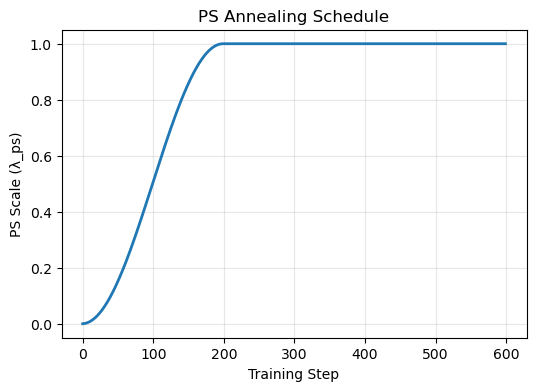

In [95]:
import numpy as np
import matplotlib.pyplot as plt

steps = np.arange(0, 600)
scales = [sched(i) for i in steps]

plt.figure(figsize=(6,4))
plt.plot(steps, scales, lw=2)
plt.title("PS Annealing Schedule")
plt.xlabel("Training Step")
plt.ylabel("PS Scale (λ_ps)")
plt.grid(True, alpha=0.3)
plt.show()

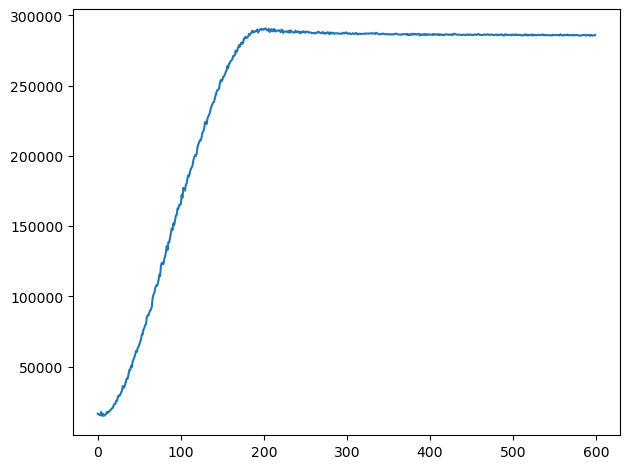

In [96]:
# Plot losses
plt.plot(losses)
plt.tight_layout()
plt.show()


Predict with svgpr+ps model

In [97]:
# use fitted model to predict on test_X:
model.eval()
with torch.no_grad():
    function_dist = model(test_X)
    # function_dist = model(test_X_all)
    gp_mean = function_dist.mean
    w = pyro.param("cox_gp_model.linear_weights")
    b = pyro.param("cox_gp_model.linear_bias")
    X_covariates = test_X[:, [2, 3]] # mean will always be LinearMean(elevation, t_s_col)
    # X_covariates = test_X_all[:, [2, 3]] # mean will always be LinearMean(elevation, t_s_col)
    linear_mean = X_covariates @ w + b
    mean = gp_mean + linear_mean

mean_np = mean.detach().cpu().numpy().ravel()

In [98]:
# predict on *all* tracts
# Use the same polygons you built earlier (areal_units), already filtered & GEOID-aligned
pred_gdf = areal_units.to_crs("EPSG:4326").copy()
pred_gdf["svgpr_ps"]    = mean_np

# safeguard renames only if those columns exist
rename_map = {}
if "centroid_lon" in pred_gdf.columns: rename_map["centroid_lon"] = "centr_lon"
if "centroid_lat" in pred_gdf.columns: rename_map["centroid_lat"] = "centr_lat"
pred_gdf = pred_gdf.rename(columns=rename_map)

# save NC shapefile (fix multiple-geometry issue)
census_group_abbrv = "bg" if census_group_type == "block_group" else "tract"
shp_path = f"ps_on_nc/nc/nc_svgpr_ps_{census_group_abbrv}_{n_inducing}_{wu_date}_{time_slot}.shp"

to_save = pred_gdf.copy()
# drop any extra geometry-typed columns other than the active geometry
geom_cols = [c for c in to_save.columns
             if getattr(to_save[c].dtype, "name", "") == "geometry" and c != to_save.geometry.name]
if geom_cols:
    to_save = to_save.drop(columns=geom_cols)

# shapefile-friendly types
to_save["svgpr_ps"] = pd.to_numeric(to_save["svgpr_ps"], errors="coerce")
to_save.to_file(shp_path)
print(f"Saved NC shapefile → {shp_path}")

Saved NC shapefile → ps_on_nc/nc/nc_svgpr_ps_bg_800_jul23_2021_eve.shp


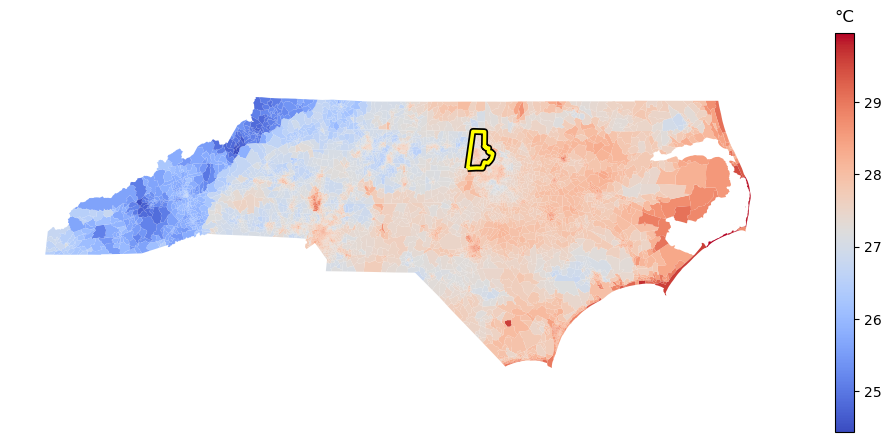

Saved PNG → ps_on_nc/nc/nc_svgpr_ps_bg_800_jul23_2021_eve.png


In [99]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
plot = pred_gdf.plot(column="svgpr_ps", cmap="coolwarm", legend=True, ax=ax, legend_kwds={"shrink": 0.7})

# Durham outline
durham_prefix = "37063"
durham_border = gpd.GeoSeries(
    pred_gdf.loc[pred_gdf["GEOID"].str.startswith(durham_prefix), "geometry"]
    .buffer(0).union_all().boundary,
    crs=pred_gdf.crs,
)
durham_border.plot(ax=ax, edgecolor="black", linewidth=5, zorder=10)
durham_border.plot(ax=ax, edgecolor="yellow", linewidth=2.5, zorder=11)

ax.set_xlabel(""); ax.set_ylabel(""); ax.set_xticks([]); ax.set_yticks([])
for s in ax.spines.values(): s.set_visible(False)
cax = plot.get_figure().axes[-1]
cax.set_ylabel(None); cax.set_title("°C", fontsize=12, pad=8)

plt.tight_layout()
png_path = f"ps_on_nc/nc/nc_svgpr_ps_{census_group_abbrv}_{n_inducing}_{wu_date}_{time_slot}.png"
plt.savefig(png_path, dpi=300, bbox_inches="tight"); plt.show()
print(f"Saved PNG → {png_path}")


In [101]:
print("linear weights:", pyro.param("cox_gp_model.linear_weights").detach().cpu().numpy())
print("linear bias:", float(pyro.param("cox_gp_model.linear_bias")))

linear weights: [0.0270144 0.8634311]
linear bias: 27.473493576049805


In [102]:
print("train_y mean (kriged °C):", float(train_y.mean()))
print("pred mean (model(test_X).mean):", float(model(test_X).mean.mean()))

print("share of zero counts:", (df_full["count"]==0).mean())
print("krige std percentiles:", np.percentile(df_full["krige_std_C"], [50,75,90,95,99]))
print("# stations in morning:", len(stations))


train_y mean (kriged °C): 27.458681106567383
pred mean (model(test_X).mean): -0.007752711419016123
share of zero counts: 0.73429337851193
krige std percentiles: [1.12853312 1.1332463  1.1407588  1.1474071  1.15853444]
# stations in morning: 2715


Paired t-test (PS - SVGP): mean diff = 0.552 °C [95% CI 0.523, 0.581], t(317) = 38.01, p = 4.25e-120
Wilcoxon signed-rank: W=0, p=6.91e-54


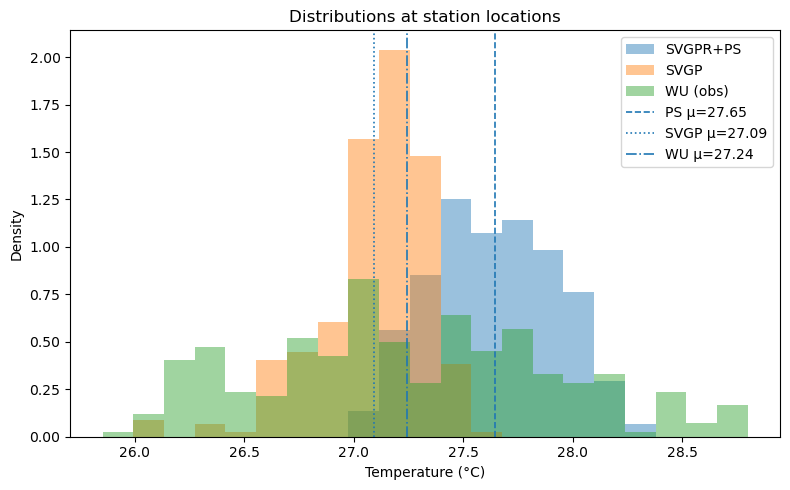

In [103]:
# ==== Add SVGP preds, align to stations, and run a paired t-test ====
from scipy import stats
from scipy.stats import t as tdist
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

svgpr_nc_gdf = gpd.read_file(
    f"ps_on_nc/nc/nc_svgpr_{census_group_abbrv}_{n_inducing}_{wu_date}_{time_slot}.shp"
).to_crs("EPSG:4326")
svgpr_nc_gdf["GEOID"] = svgpr_nc_gdf["GEOID"].astype(str)

# 1) Keep polygons with BOTH predictions (SVGPR+PS + SVGP)
#    svgpr_gdf already loaded above and renamed: column "svgpr"
poly_ps  = pred_gdf[["GEOID", "geometry", "svgpr_ps"]].copy().to_crs(4326)
poly_svg = svgpr_nc_gdf.rename(columns={"pred_temp":"svgpr"})
poly_svg = poly_svg[["GEOID", "svgpr"]].copy()  # same GEOIDs
poly_both = poly_ps.merge(poly_svg, on="GEOID", how="inner")

# Restrict to a county
# poly_both = poly_both[poly_both["GEOID"].astype(str).str.startswith(county_prefix)].copy()
poly_both = poly_both[poly_both["GEOID"].astype(str).str.startswith(tuple(county_prefixes))].copy()

# 2) Stations as GeoDataFrame (slot-filtered WU obs)
gdf_pts = gpd.GeoDataFrame(
    stations.copy(),
    geometry=gpd.points_from_xy(stations["lon"], stations["lat"]),
    crs=4326,
)

# 3) Spatial join: give each station BOTH preds from the polygon it falls in
pts = gpd.sjoin(gdf_pts, poly_both[["GEOID","svgpr_ps","svgpr","geometry"]],
                how="inner", predicate="within").drop(columns="index_right")

# 4) Arrays
ps   = pts["svgpr_ps"].to_numpy()
svgp = pts["svgpr"].to_numpy()
tru  = pts["tempAvg"].to_numpy()
m = np.isfinite(ps) & np.isfinite(svgp) & np.isfinite(tru)
ps, svgp, tru = ps[m], svgp[m], tru[m]

# 5) Paired t-test: SVGPR+PS vs SVGP (paired by station’s polygon)
tstat, pval = stats.ttest_rel(ps, svgp, nan_policy="omit")
diff = ps - svgp
diff = diff[np.isfinite(diff)]
n = diff.size
md = diff.mean()
sd = diff.std(ddof=1)
alpha = 0.05
tcrit = tdist.ppf(1 - alpha/2, df=n-1)
ci_lo, ci_hi = md - tcrit*sd/np.sqrt(n), md + tcrit*sd/np.sqrt(n)
print(f"Paired t-test (PS - SVGP): mean diff = {md:.3f} °C "
      f"[95% CI {ci_lo:.3f}, {ci_hi:.3f}], t({n-1}) = {tstat:.2f}, p = {pval:.3g}")

# (Optional) nonparametric confirmation
w_stat, w_p = stats.wilcoxon(ps, svgp, zero_method="wilcox", alternative="two-sided", method="approx")
print(f"Wilcoxon signed-rank: W={w_stat:.0f}, p={w_p:.3g}")

# 6) Three-way histogram: WU vs SVGP vs SVGPR+PS
vals = np.r_[tru, svgp, ps]
lo = np.nanpercentile(vals, 1); hi = np.nanpercentile(vals, 99)
bins = np.linspace(lo, hi, 22)

plt.figure(figsize=(8,5))
plt.hist(ps,   bins=bins, density=True, alpha=0.45, label="SVGPR+PS", edgecolor="none")
plt.hist(svgp, bins=bins, density=True, alpha=0.45, label="SVGP",     edgecolor="none")
plt.hist(tru,  bins=bins, density=True, alpha=0.45, label="WU (obs)", edgecolor="none")

for arr, ls, name in [(ps,"--","PS μ"), (svgp,":","SVGP μ"), (tru,"-.", "WU μ")]:
    plt.axvline(arr.mean(), ls=ls, lw=1.2, label=f"{name}={arr.mean():.2f}")

plt.xlabel("Temperature (°C)"); plt.ylabel("Density")
plt.title("Distributions at station locations")
plt.legend()
plt.tight_layout()
plt.show()


#### NOAA Validation (do for all cities except Chapel Hill!)

In [104]:
import rasterio
import rasterio.mask
import geopandas as gpd
from shapely.geometry import mapping
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from rasterstats import zonal_stats
from scipy.stats import pearsonr

In [105]:
if city_name == "chapel_hill":
    raise SystemExit # Stop the cell here (don't do NOAA Validation)

noaa_time_slot = "pm" if time_slot == 'eve' else "am"
noaa_trav_locs = "raleigh_durham" if city_name in ["durham", "raleigh"] else city_name

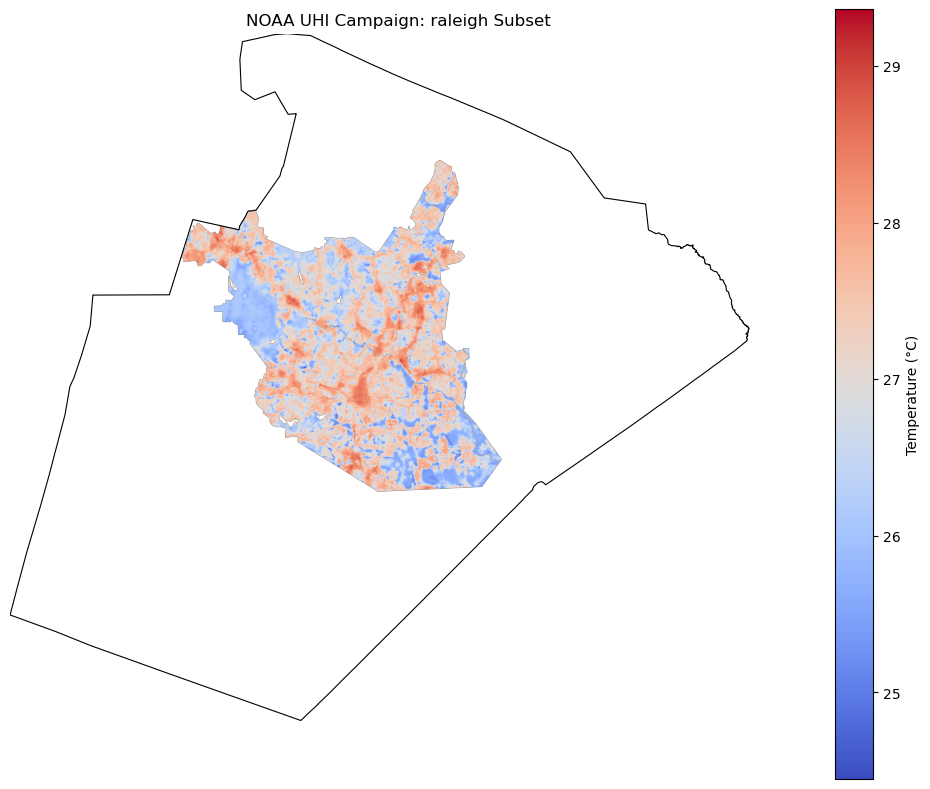

In [106]:
city_units_with_preds = gpd.read_file(f"ps_on_nc/{city_name}/{city_name}_svgpr_ps_{census_group_abbrv}_{n_inducing}_{wu_date}_{time_slot}.shp")

# 2. Match CRS between shapefile and raster
with rasterio.open(f"data/noaa_{city_name}/{noaa_trav_locs}_noaa_{noaa_time_slot}.tif") as src:
    raster_crs = src.crs
    city_units_proj = city_units_with_preds.to_crs(raster_crs)

    # 3. Clip raster to Durham geometries
    shapes = [mapping(geom) for geom in city_units_proj.geometry]
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta.copy()

# 4. Clean and convert Fahrenheit → Celsius
out_image = out_image.astype(np.float32)
out_image_clean = np.where((out_image > -40) & (out_image < 150), out_image, np.nan)
out_image_celsius = (out_image_clean - 32) * 5.0 / 9.0

from rasterio.plot import plotting_extent

# extent from the *cropped* transform
extent = plotting_extent(out_image_celsius[0], out_transform)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(
    out_image_celsius[0],
    extent=extent,     # <-- place pixels correctly
    origin="upper",    # north-up (raster origin is top-left)
    cmap="coolwarm",
)
plt.colorbar(im, ax=ax, label="Temperature (°C)")

# Optional: dissolve to a single Durham outline for a clean border
city_outline = city_units_proj.dissolve()  # merges all block groups
city_outline.boundary.plot(ax=ax, color="black", linewidth=0.8)

plt.title(f"NOAA UHI Campaign: {city_name} Subset")
plt.axis("off")
plt.tight_layout()
plt.show()


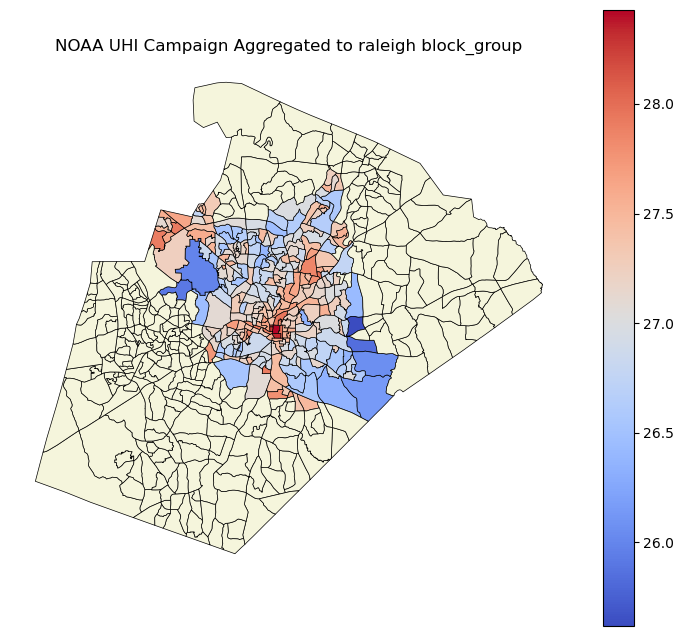

In [107]:
# 3) Zonal stats using the CROPPED transform
from rasterstats import zonal_stats

stats = zonal_stats(
    vectors=city_units_proj,            # GeoDataFrame is fine
    raster=out_image_celsius[0],                    # numpy array
    affine=out_transform,               # <-- critical
    stats=["mean"],
    nodata=np.nan,
    all_touched=False                   # set True if you want partial-pixel inclusion
)

city_units_proj["noaa_temp"] = [s["mean"] for s in stats]

# 4) Plot, showing polygons with no data as gray
ax = city_units_proj.plot(
    column="noaa_temp", cmap="coolwarm", legend=True, figsize=(9,8),
    edgecolor="black", linewidth=0.5,
    missing_kwds={"color": "beige", "label": "no NOAA coverage"}
)
plt.title(f"NOAA UHI Campaign Aggregated to {city_name} {census_group_type}")
plt.axis("off")
plt.show()

In [108]:
# Compute NOAA tract data to ExactGP predictions and LGCP+GP predictions:

lgcp_gp_gdf = gpd.read_file(f"ps_on_nc/{city_name}/{city_name}_lgcp_gp_{census_group_abbrv}_800_{wu_date}_{time_slot}.shp")
lgcp_gp_gdf["GEOID"] = lgcp_gp_gdf["GEOID"].astype(str)
svgpr_gdf = gpd.read_file(f"ps_on_nc/{city_name}/{city_name}_svgpr_{census_group_abbrv}_{n_inducing}_{wu_date}_{time_slot}.shp")
svgpr_gdf["GEOID"] = svgpr_gdf["GEOID"].astype(str)
svgpr_gdf = svgpr_gdf.rename(columns={"pred_temp": "svgpr"})
svgpr_ps_gdf = gpd.read_file(f"ps_on_nc/{city_name}/{city_name}_svgpr_ps_{census_group_abbrv}_{n_inducing}_{wu_date}_{time_slot}.shp")
svgpr_ps_gdf["GEOID"] = svgpr_ps_gdf["GEOID"].astype(str)
city_units_proj["GEOID"] = city_units_proj["GEOID"].astype(str)

df_compare = pd.merge(
    city_units_proj[["GEOID", "noaa_temp", "svgpr_ps"]],
    lgcp_gp_gdf[["GEOID", "lgcp_gp"]],
    on="GEOID",
    how="inner"
)

df_compare = pd.merge(
    df_compare,
    svgpr_gdf[["GEOID", "svgpr"]],
    on="GEOID",
    how="inner"
)

# Now drop any rows that are missing any of the columns involved in correlation
df_compare = df_compare.dropna(subset=["lgcp_gp", "noaa_temp", "svgpr_ps", "svgpr"])

print(f"{census_group_type} data ({city_name}) - {time_slot}:")
r_svgpr, p_svgpr = pearsonr(df_compare["svgpr"], df_compare["noaa_temp"])
print(f"SVGPR vs NOAA TIF: r = {r_svgpr:.2f}, p = {p_svgpr:.2e}")
r_svgpr_ps, p_svgpr_ps = pearsonr(df_compare["svgpr_ps"], df_compare["noaa_temp"])
print(f"SVGPR+PS vs NOAA TIF: r = {r_svgpr_ps:.2f}, p = {p_svgpr_ps:.2e}")
r_lgcp_gp, p_lgcp_gp = pearsonr(df_compare["lgcp_gp"], df_compare["noaa_temp"])
print(f"LGCP+GP vs NOAA TIF: r = {r_lgcp_gp:.2f}, p = {p_lgcp_gp:.2e}")
print(f"SVGPR+PS - SVGPR: r_2 - r_1 = {r_svgpr_ps - r_svgpr:.2f}")
print(f"LGCP+GP - SVGPR: r_3 - r_1 = {r_lgcp_gp - r_svgpr:.2f}")

block_group data (raleigh) - eve:
SVGPR vs NOAA TIF: r = 0.28, p = 7.71e-07
SVGPR+PS vs NOAA TIF: r = 0.47, p = 9.36e-18
LGCP+GP vs NOAA TIF: r = 0.39, p = 5.36e-12
SVGPR+PS - SVGPR: r_2 - r_1 = 0.19
LGCP+GP - SVGPR: r_3 - r_1 = 0.10


Shared color scale: 26.10-28.10 °C


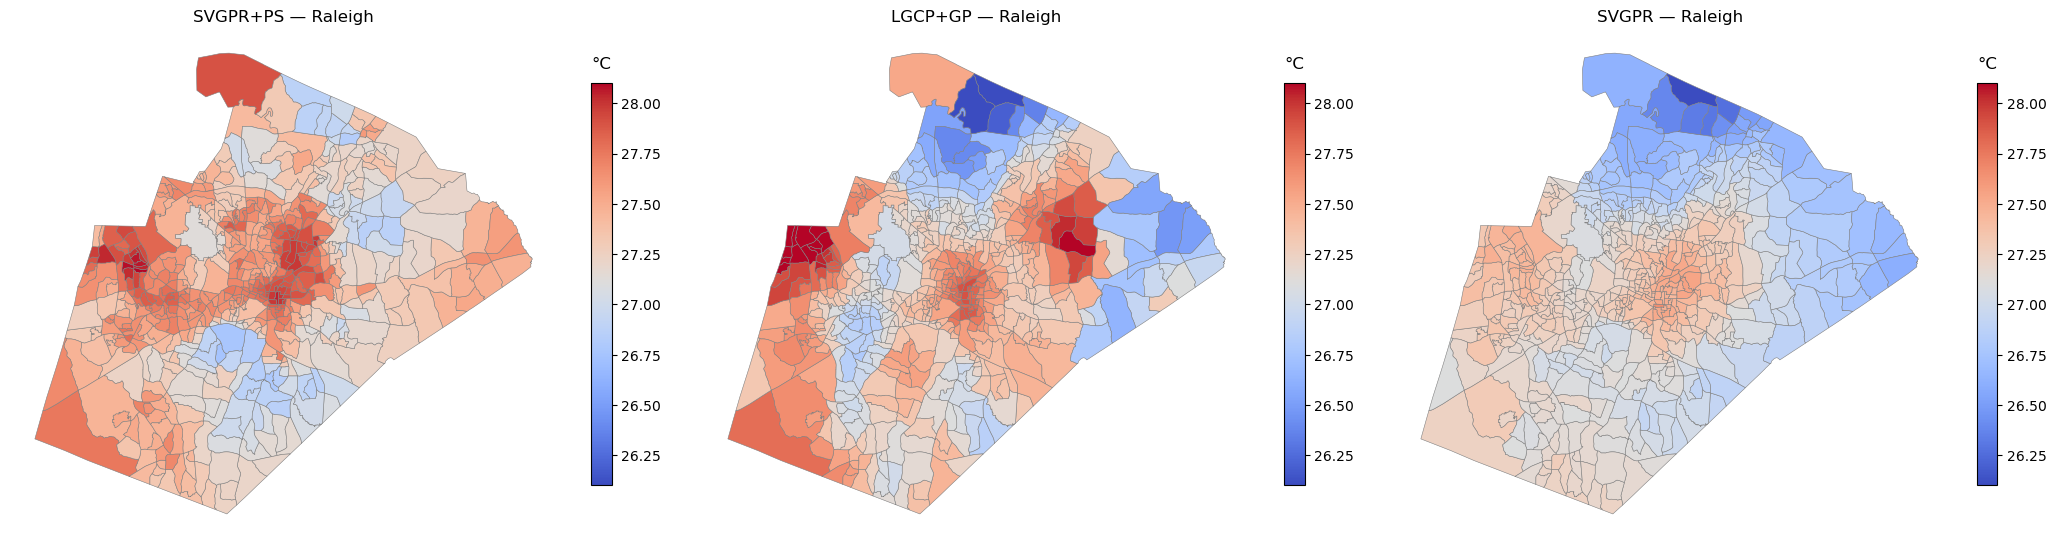

In [110]:
# Compute shared vmin/vmax for consistent color scale
vmin = min(
    svgpr_ps_gdf["svgpr_ps"].min(),
    # lgcp_gp_gdf["lgcp_gp"].min(),
    svgpr_gdf["svgpr"].min() )
vmax = max(
    svgpr_ps_gdf["svgpr_ps"].max(),
    # lgcp_gp_gdf["lgcp_gp"].max(),
    svgpr_gdf["svgpr"].max() )

print(f"Shared color scale: {vmin:.2f}-{vmax:.2f} °C")

# Setup figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# SVGPR+PS
svgpr_ps_gdf.plot(
    column="svgpr_ps",
    cmap="coolwarm",
    edgecolor="gray",
    linewidth=0.4,
    legend=True,
    ax=axs[0],
    vmin=vmin, vmax=vmax,
    legend_kwds={"shrink": 0.6}
)
axs[0].set_title(f"SVGPR+PS — {city_name.capitalize()}")
axs[0].set_axis_off()

# LGCP+GP
lgcp_gp_gdf.plot(
    column="lgcp_gp",
    cmap="coolwarm",
    edgecolor="gray",
    linewidth=0.4,
    legend=True,
    ax=axs[1],
    vmin=vmin, vmax=vmax,
    legend_kwds={"shrink": 0.6}
)
axs[1].set_title(f"LGCP+GP — {city_name.capitalize()}")
axs[1].set_axis_off()

# SVGPR
svgpr_gdf.plot(
    column="svgpr",
    cmap="coolwarm",
    edgecolor="gray",
    linewidth=0.4,
    legend=True,
    ax=axs[2],
    vmin=vmin, vmax=vmax,
    legend_kwds={"shrink": 0.6}
)
axs[2].set_title(f"SVGPR — {city_name.capitalize()}")
axs[2].set_axis_off()

for cb_ax in fig.axes[3:]:
    cb_ax.set_title("°C", fontsize=12, pad=10)

plt.tight_layout()
plt.show()
